Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9


Wrote a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, November 27
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [109]:
import numpy as np
import random
from tqdm import tqdm
from copy import deepcopy

from utils.reproduce_functions import *
from utils.mutation_functions import *
from utils.parent_selection_functions import *
from utils.other_fucntions import *
from utils.island_functions import *

import lab9_lib

In [110]:
PROBLEM_SIZE = 2

MU = 15
LAMBDA = 30
strategy = 'plus' # comma or plus

MUTATION_PROB = 0.2
DYNAMIC_MUTATION_PROB = True
DIVERSITY_THRESHOLD = 20

LENGTH_SOLUTION = 1000
NUMBER_GENERATIONS = 3000
COOLDOWN_TIME = 100

NUM_ISLANDS = 5

In [111]:
# Function to perform swapping between islands
mutate = one_bit_flip
reproduce = two_cuts_crossover
parent_selection = roulette

when_to_swap = fitness_based 
swap_individuals_between_islands = fitness_based_migration

In [112]:
def ga(fitness, islands, islands_evals, memoization=False, history=None):
    if memoization:
        pop_history = {}
        for i in range(len(islands_evals)):
            for j in range(len(islands_evals[i])):
                pop_history[islands[i][j].tobytes()] = islands_evals[i][j]

    best_value = -1 
    last_change = 0
    
    for generation in tqdm(range(NUMBER_GENERATIONS)):
        for island_ix, island in enumerate(islands):
            parents = island
            parents_evals = islands_evals[island_ix]
            offsprings = []
            offsprings_evals = []

            while len(offsprings) < LAMBDA:
                
                p1, p2 = parent_selection(parents, parents_evals)
    
                # Reproduce Parents
                off_spring = reproduce(p1, p2)
                
               # Mutate Offspring
                if DYNAMIC_MUTATION_PROB:
                    p_div = get_parents_diversity(p1, p2)
                    new_ind1 = mutate(off_spring, \
                                    mutation_probability=(1 - (min(p_div,LENGTH_SOLUTION/2)/(LENGTH_SOLUTION/2))) )
                else:    
                    new_ind1 = mutate(off_spring, mutation_probability=MUTATION_PROB)

                # Evaluate Offspring
                if memoization:
                    new_ind1_eval = pop_history.get(new_ind1.tobytes())
                    if new_ind1_eval == None:
                        new_ind1_eval = fitness(new_ind1)
                        pop_history[new_ind1.tobytes()] = new_ind1_eval

                else:
                    new_ind1_eval = fitness(new_ind1)

                offsprings.append(new_ind1)

                offsprings_evals.append(new_ind1_eval)
                if memoization:
                    pop_history[new_ind1.tobytes()] = new_ind1_eval

            # Create new population (with parents if plus, without if comma)
            all_people = (parents if strategy=='plus' else []) + offsprings
            all_evals = (parents_evals if strategy=='plus' else []) + offsprings_evals
            best_people = np.argsort(all_evals)[::-1]

            if history is not None:
                history[island_ix].append(np.max(all_evals))

            parents = []
            parents_evals = []
            for i in range(MU):
                parents.append(all_people[best_people[i]])
                parents_evals.append(all_evals[best_people[i]])
            islands[island_ix] = parents
            islands_evals[island_ix] = parents_evals
            
            # if np.max(parents_evals) - 1.0 >= 0:
            #     print(f"Early stopping {generation=}")
                # return parents, parents_evals

        best_eval = max([max(x) for x in history])
        if best_eval > best_value:
            best_value = best_eval
            last_change = generation
        elif generation - last_change > COOLDOWN_TIME:
            break

        if when_to_swap(islands_evals):
            swap_individuals_between_islands(islands, islands_evals)
            # swap_individuals_between_islands(islands)

        # if when_to_swap(generation, 10):
        #     # swap_individuals_between_islands(islands, islands_evals)
        #     swap_individuals_between_islands(islands, islands_evals)

    return islands, islands_evals

Without memoization

In [113]:
'''
fitness = lab9_lib.make_problem(PROBLEM_SIZE)
islands = [ [generate_random_individual(length=LENGTH_SOLUTION) for _ in range(50) ] for _ in range(NUM_ISLANDS) ]
islands_evals = [[fitness(x) for x in island] for island in islands ]
parents, parents_evals = ga(fitness, islands, islands_evals, memoization=False)
i_best = np.argmax(parents_evals)
print(parents[i_best])
print("Best score: ", parents_evals[i_best])
print("Num fitness calls: ", fitness.calls)
'''

'\nfitness = lab9_lib.make_problem(PROBLEM_SIZE)\nislands = [ [generate_random_individual(length=LENGTH_SOLUTION) for _ in range(50) ] for _ in range(NUM_ISLANDS) ]\nislands_evals = [[fitness(x) for x in island] for island in islands ]\nparents, parents_evals = ga(fitness, islands, islands_evals, memoization=False)\ni_best = np.argmax(parents_evals)\nprint(parents[i_best])\nprint("Best score: ", parents_evals[i_best])\nprint("Num fitness calls: ", fitness.calls)\n'

With memoization

In [114]:
fitness_calls = []
best_scores = []
for i in range(30):
    fitness = lab9_lib.make_problem(PROBLEM_SIZE)
    
    history = [[] for _ in range(NUM_ISLANDS)]
    islands = [ [generate_random_individual(length=LENGTH_SOLUTION) for _ in range(50) ] for _ in range(NUM_ISLANDS) ]
    islands_evals = [[fitness(x) for x in island] for island in islands]
    parents, parents_evals = ga(fitness, islands, islands_evals, memoization=True, history=history)
    print(max([max(x) for x in history]))
    #i_best = np.argmax(parents_evals)
    #print(parents[i_best])
    #print("Best score: ", parents_evals[i_best])
    print("Num fitness calls: ", fitness.calls)
    fitness_calls.append(fitness.calls)
    best_scores.append(np.max(history))

print("average fitness calls: ", np.mean(fitness_calls))
print("average best score: ", np.mean(best_scores))

  0%|          | 2/3000 [00:00<02:57, 16.85it/s]

 19%|█▊        | 557/3000 [00:27<01:59, 20.40it/s]


0.838
Num fitness calls:  83934


 69%|██████▉   | 2077/3000 [01:50<00:48, 18.85it/s]


0.964
Num fitness calls:  311905


 50%|█████     | 1506/3000 [01:18<01:17, 19.21it/s]


0.894
Num fitness calls:  226280


 21%|██        | 620/3000 [00:29<01:54, 20.76it/s]


0.974
Num fitness calls:  93395


 21%|██        | 636/3000 [00:30<01:53, 20.74it/s]


0.948
Num fitness calls:  95789


 11%|█▏        | 338/3000 [00:14<01:56, 22.78it/s]


0.73
Num fitness calls:  51085


 15%|█▌        | 458/3000 [00:20<01:54, 22.18it/s]


0.72
Num fitness calls:  69089


 30%|███       | 904/3000 [00:43<01:40, 20.86it/s]


0.986
Num fitness calls:  135967


 13%|█▎        | 388/3000 [00:19<02:11, 19.87it/s]


0.728
Num fitness calls:  58588


 34%|███▍      | 1026/3000 [00:50<01:36, 20.36it/s]


0.93
Num fitness calls:  154286


 38%|███▊      | 1141/3000 [00:53<01:27, 21.26it/s]


0.828
Num fitness calls:  171521


 36%|███▌      | 1077/3000 [00:53<01:34, 20.30it/s]


0.994
Num fitness calls:  161908


  6%|▌         | 169/3000 [00:06<01:52, 25.26it/s]


0.606
Num fitness calls:  25747


 29%|██▉       | 875/3000 [00:40<01:37, 21.72it/s]


0.98
Num fitness calls:  131630


 20%|██        | 613/3000 [00:29<01:54, 20.83it/s]


0.836
Num fitness calls:  92332


 15%|█▌        | 457/3000 [00:20<01:54, 22.25it/s]


0.772
Num fitness calls:  68947


 17%|█▋        | 514/3000 [00:25<02:02, 20.36it/s]


0.952
Num fitness calls:  77489


 51%|█████     | 1516/3000 [01:15<01:13, 20.16it/s]


0.988
Num fitness calls:  227740


 45%|████▍     | 1342/3000 [01:07<01:23, 19.83it/s]


0.912
Num fitness calls:  201658


 18%|█▊        | 547/3000 [00:26<01:58, 20.74it/s]


0.97
Num fitness calls:  82443


 15%|█▌        | 460/3000 [00:24<02:15, 18.75it/s]


0.732
Num fitness calls:  69389


 12%|█▏        | 359/3000 [00:16<02:04, 21.19it/s]


0.7
Num fitness calls:  54243


 69%|██████▉   | 2080/3000 [01:48<00:47, 19.18it/s]


0.988
Num fitness calls:  312361


 18%|█▊        | 532/3000 [00:23<01:51, 22.20it/s]


0.756
Num fitness calls:  80178


 14%|█▍        | 419/3000 [00:19<02:00, 21.40it/s]


0.878
Num fitness calls:  63245


 12%|█▏        | 370/3000 [00:17<02:05, 21.04it/s]


0.716
Num fitness calls:  55897


 18%|█▊        | 540/3000 [00:26<02:02, 20.15it/s]


0.994
Num fitness calls:  81380


 21%|██        | 628/3000 [00:32<02:01, 19.57it/s]


0.936
Num fitness calls:  94581


 21%|██        | 625/3000 [00:30<01:55, 20.52it/s]


0.884
Num fitness calls:  94136


 11%|█▏        | 340/3000 [00:15<01:58, 22.36it/s]

0.754
Num fitness calls:  51395
average fitness calls:  115951.26666666666
average best score:  0.8629333333333334


In [115]:
len(history)

5

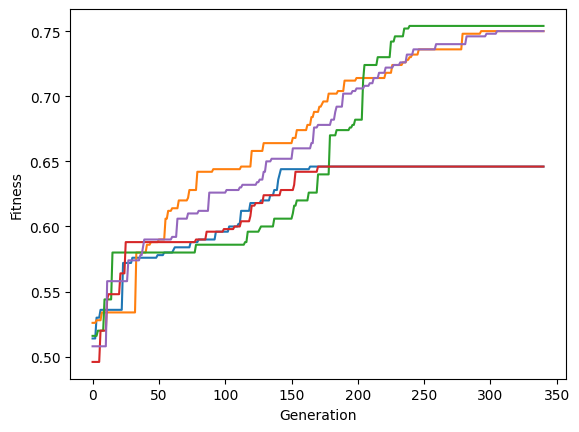

In [116]:
# plot history

# plot history
import matplotlib.pyplot as plt
for x in history:
    plt.plot(x)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.show()